In [1]:
from sklearn.datasets import fetch_openml
from sklearn import preprocessing
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [2]:
ds = fetch_openml('mnist_784')
x, y = ds.data, ds.target

In [3]:
cutoff = 60000
training_x = x[:cutoff]
training_y = y[:cutoff]
validation_x = x[cutoff:]
validation_y = y[cutoff:]

In [4]:
train_ix = np.logical_or(training_y == '0', training_y == '1')
val_ix = np.logical_or(validation_y == '0', validation_y == '1')

In [5]:
train_x = training_x[train_ix]
train_y = training_y[train_ix]

val_x = validation_x[val_ix]
val_y = validation_y[val_ix]

In [6]:
print(train_x.shape, val_x.shape)

(12665, 784) (2115, 784)


In [31]:
def resize_images(df, old, new):
    df_temp = df
    num_samples = df_temp.shape[0]
    df_temp = df_temp.reshape((num_samples, old, old))
    downsized = np.zeros((num_samples, new, new))
    for ix in range(num_samples):
        downsized[ix] = cv2.resize(df_temp[ix], (new, new))
    downsized = downsized.reshape((num_samples, new**2))
    return downsized

def shuffle_dataset(X, Y):
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)

    return X[indices], Y[indices]

def batch_generator(X, Y, batch_size):
    while True:
        X, Y = shuffle_dataset(X, Y)
        for i in range((X.shape[0] - batch_size) // batch_size):
            yield X[i * batch_size: i * batch_size + batch_size], Y[i * batch_size: i * batch_size + batch_size]
    return x_batch, y_batch

In [8]:
resized_train_x = resize_images(train_x, 28, 14)
resized_val_x = resize_images(val_x, 28, 14)

In [9]:
label_changer = lambda x: 1 if x == '0' else -1
vector_func = np.vectorize(label_changer)
labeled_train_y = vector_func(train_y)
labeled_val_y = vector_func(val_y)

In [10]:
w = np.random.rand(resized_train_x.shape[1])
b = np.random.rand(1)

In [11]:
class linear_t:
    def __init__(self):
        
        self.w = np.random.rand(resized_train_x.shape[1] + 1)
        
        self.hl = None
        self.dw = 0.0
        
    def forward(self, h_l):
        
        bias_row = np.ones((h_l.shape[0], 1))
        appended_x = np.concatenate((h_l, bias_row), axis = 1)
        h_l = appended_x
        
        h_l1 = np.matmul(h_l, np.transpose(self.w))
        self.hl = h_l
        return h_l1
    
    def backward(self, dh_l1):
        dh_l = np.matmul(dh_l1, self.w)
        dw = np.matmul(dh_l1.T, self.hl)
                
        self.dw = dw
        return dh_l
    
    def zero_grad(self):
        self.dw = 0.0 * self.dw

In [38]:
class log_loss_nesterov:
    def __init__(self):
        self.y = 0.0
        self.yhat = 0.0
        self.w = 0.0
        self.lam = 0.0
        
    def forward(self, x, y, yhat, w, lam):
        loss = 0
                
        for i in range(len(y)):
            loss_i = np.log(1 + np.exp(-y[i] * yhat[i]))
            loss += loss_i
        loss /= len(y)
        
        lambda_loss = lam/2 * np.linalg.norm(w, 2)
        loss += lambda_loss
        
        self.y = y
        self.yhat = yhat
        self.w = w
        self.lam = lam
        
        bias_row = np.ones((x.shape[0], 1))
        appended_x = np.concatenate((x, bias_row), axis = 1)
        self.x = appended_x
        
        pred_val = lambda x: 1 if x < 0 else -1
        vector_func = np.vectorize(pred_val)
        pred = vector_func(yhat)
        acc = np.sum(pred == y) / len(pred)
        return 1 - acc, loss
    
    def backward(self, new_w):
        dw = 0.0
        for i in range(len(self.y)):
            e_term = np.exp(-self.y[i] * np.matmul(self.x[i], np.transpose(new_w)))
            dw += self.x[i] *((self.y[i] * e_term) / (1 + e_term))
        dw /= len(y)
        dw += self.lam * np.linalg.norm(new_w, 1)
        return dw
    
    def zero_grad(self):
        return

In [66]:
lr = 1e-4
lam = 1e-4
k = 0.071
L = 0.054
gamma = L / k

In [67]:
l1, l3 = linear_t(), log_loss_nesterov()
last_update = l1.w
net = [l1, l3]

In [68]:
train_error_list, train_loss_list, val_error_list, val_loss_list = [], [], [], []

In [69]:
x_full, y_full = preprocessing.scale(resized_train_x), labeled_train_y
x_val_full, y_val_full = preprocessing.scale(resized_val_x), labeled_val_y

In [70]:
train_dataloader = batch_generator(x_full, y_full, batch_size=128)
val_dataloarder = batch_generator(x_val_full, y_val_full, batch_size=128)

In [72]:
for t in range(int(1e4)):
    
    x, y = train_dataloader.__next__()
    x_val, y_val = val_dataloarder.__next__()
    
    for l in net:
        l.zero_grad()
        
    hl = l1.forward(x)
    ell, error = l3.forward(x, y, hl, l1.w, lam)
    
    if(not (t % 1e2)):
        print(t, ell, error)
    
    train_loss_list.append(ell)
    train_error_list.append(error)
    
    hl = l1.forward(x_val)
    
    val_loss, val_error = l3.forward(x_val, y_val, hl, l1.w, lam)
    
    val_loss_list.append(val_loss)
    val_error_list.append(val_error)
    
    momentum = gamma * last_update
    dw = l3.backward(l1.w - momentum)
    nesterov_dw = momentum + lr * dw
    last_update = nesterov_dw
    
    l1.w = l1.w - nesterov_dw

0 0.953125 0.5792076782310736
100 0.0546875 41.911577195884064
200 0.046875 42.6682933926677
300 0.046875 36.797621628225
400 0.046875 41.78772670181735
500 0.0625 41.0855096802674
600 0.0625 45.836102101861364
700 0.0546875 43.827718377609216
800 0.0390625 44.95076995664035
900 0.0546875 44.85697722344792
1000 0.03125 46.1804932395404
1100 0.0390625 46.76670089362063
1200 0.0390625 50.434429617608416
1300 0.046875 50.65782608543569
1400 0.0546875 49.42607256127503
1500 0.0390625 52.527562616382205
1600 0.0703125 52.8196788048346
1700 0.0390625 53.558448967613224
1800 0.0546875 58.568552903310014
1900 0.03125 58.14984590995401
2000 0.0234375 62.966193566636825
2100 0.03125 57.697644548847975
2200 0.046875 59.95725781530668
2300 0.046875 61.65794846572439
2400 0.046875 62.793045860239
2500 0.0234375 64.8551955149378
2600 0.046875 71.2668452418252
2700 0.0078125 63.091127220030664
2800 0.03125 65.44970831772514
2900 0.046875 67.1336083072484
3000 0.03125 74.27319157727277
3100 0.0390625 

In [73]:
log_train_loss = [np.log(x) for x in train_loss_list]
log_val_loss = [np.log(x) for x in val_loss_list]

/home/sheil/miniconda3/envs/TF/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.
/home/sheil/miniconda3/envs/TF/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


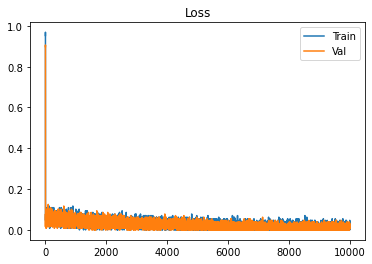

In [74]:
plt.plot(train_loss_list, label='Train')
plt.plot(val_loss_list, label='Val')
plt.legend()
plt.title('Loss')
plt.show()